In [16]:
from benchmark_consts import get_problems, get_args_and_problems, print_, PATH_FORM_HYPERPARAMS

import os
import pickle
import traceback
import argparse
import random
import math

import sys
sys.path.append('..')

from lib.algorithms import PathFormulation
from lib.problem import Problem

import matplotlib.pyplot as plt
%matplotlib inline

TOP_DIR = 'path-form-logs'
HEADERS = [
    'problem', 'num_nodes', 'num_edges', 'traffic_seed', 'scale_factor',
    'tm_model', 'num_commodities', 'total_demand', 'algo', 'num_paths',
    'edge_disjoint', 'dist_metric', 'total_flow', 'runtime'
]
PLACEHOLDER = ','.join('{}' for _ in HEADERS)


In [23]:
#Input: a Problem, and a list of number representing the divisions
def split_problem(problem, num_subproblems):
    sub_problems = []
    num_rows = len(problem.traffic_matrix.tm)
    rows_per_problem = math.floor(num_rows/num_subproblems)
    shuffled_indices = list(range(num_rows))
    
    for i in range(num_subproblems):
        
        sub_problems.append(problem.copy())
        for indx, j in enumerate(shuffled_indices):
            
            # zero out all rows except those in the corresponding block of shuffled indices
            # first, cover special case for last block
            if i == num_subproblems-1:
                if indx < i*rows_per_problem:
                    sub_problems[-1].traffic_matrix.tm[j,:] = 0
            
            elif (indx < i*rows_per_problem) or (indx >= (i+1)*rows_per_problem):
                sub_problems[-1].traffic_matrix.tm[j,:] = 0
            
        # split the capacity of each link
        for u,v in sub_problems[-1].G.edges:
            sub_problems[-1].G[u][v]['capacity'] = sub_problems[-1].G[u][v]['capacity']/num_subproblems

    return sub_problems
        
# Sweep topos and traffic matrices for that topo. For each combo, record the
# runtime and total flow for each algorithm
def benchmark_split(problems, num_subproblems_list):
    num_paths, edge_disjoint, dist_metric = PATH_FORM_HYPERPARAMS
    all_results = {}
    all_runtimes = {}
    with open('path-form.csv', 'a') as results:
        print_(','.join(HEADERS), file=results)
        for problem_name, topo_fname, tm_fname in problems:
            problem = Problem.from_file(topo_fname, tm_fname)
            
            problem_results = [[] for _ in range(len(num_subproblems_list))]
            problem_runtimes = [[] for _ in range(len(num_subproblems_list))]
            for nsp_i, num_subproblems in enumerate(num_subproblems_list):
                
                problem_list = split_problem(problem, num_subproblems)
                sum_obj_val = 0
                for sp_i, sub_problem in enumerate(problem_list):

                    print_(sub_problem.name, tm_fname)
                    traffic_seed = sub_problem.traffic_matrix.seed
                    total_demand = sub_problem.total_demand
                    print_('traffic seed: {}'.format(traffic_seed))
                    print_('traffic scale factor: {}'.format(
                        sub_problem.traffic_matrix.scale_factor))
                    print_('traffic matrix model: {}'.format(
                        sub_problem.traffic_matrix.model))
                    print_('total demand: {}'.format(total_demand))

                    run_dir = os.path.join(
                        TOP_DIR, sub_problem.name,
                        '{}-{}'.format(traffic_seed, sub_problem.traffic_matrix.model))
                    if not os.path.exists(run_dir):
                        os.makedirs(run_dir)

                    try:
                        print_(
                            '\nPath formulation, {} paths, edge disjoint {}, dist metric {}'
                            .format(num_paths, edge_disjoint, dist_metric))
                        with open(
                                os.path.join(
                                    run_dir,
                                    '{}-path-formulation_{}-paths_edge-disjoint-{}_dist-metric-{}.txt'
                                    .format(sub_problem.name, num_paths, edge_disjoint,
                                            dist_metric)), 'w') as log:
                            pf = PathFormulation.new_max_flow(
                                num_paths,
                                edge_disjoint=edge_disjoint,
                                dist_metric=dist_metric,
                                out=log)

                            pf.solve(sub_problem)
                            pf_sol_dict = pf.extract_sol_as_dict()
                            with open(
                                    os.path.join(
                                        run_dir,
                                        '{}-path-formulation_{}-paths_edge-disjoint-{}_dist-metric-{}_sol-dict.pkl'
                                        .format(sub_problem.name, num_paths, edge_disjoint,
                                                dist_metric)), 'wb') as w:
                                pickle.dump(pf_sol_dict, w)

                        result_line = PLACEHOLDER.format(
                            sub_problem.name,
                            len(sub_problem.G.nodes),
                            len(sub_problem.G.edges),
                            traffic_seed,
                            sub_problem.traffic_matrix.scale_factor,
                            sub_problem.traffic_matrix.model,
                            len(problem.commodity_list),
                            total_demand,
                            'path_formulation',
                            num_paths,
                            edge_disjoint,
                            dist_metric,
                            pf.obj_val,
                            pf.runtime,
                        )
                        print_(result_line, file=results)
                        problem_results[nsp_i].append(pf.obj_val)
                        problem_runtimes[nsp_i].append(pf.runtime)
                        sum_obj_val += pf.obj_val
                    except Exception:
                        print_(
                            'Path formulation {} paths, edge disjoint {}, dist metric {}, Problem {}, traffic seed {}, traffic model {} failed'
                            .format(num_paths, edge_disjoint, dist_metric,
                                    sub_problem.name, traffic_seed,
                                    sub_problem.traffic_matrix.model))
                        traceback.print_exc(file=sys.stdout)
                print("sum of obj vals: " + str(sum_obj_val))
               
            all_results[(problem_name, topo_fname, tm_fname)] = problem_results
            all_runtimes[(problem_name, topo_fname, tm_fname)] = problem_runtimes
    return all_results, all_runtimes

In [24]:
parser = argparse.ArgumentParser()
parser.add_argument('--dry-run',
                        dest='dry_run',
                        action='store_true',
                        default=False)

parser.add_argument('--slices',
                        type=int,
                        choices=range(5),
                        nargs='+',
                        required=True)
args = parser.parse_args("--slices 0".split())

if not os.path.exists(TOP_DIR):
    os.makedirs(TOP_DIR)

#problems = get_problems(args)

if args.dry_run:
    print('Problems to run:')
    for problem in problems:
        print(problem)

problem_spec = ("temp", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl")
num_subproblems = [1,2,4,8]
problems = [problem_spec]
results, runtimes = benchmark_split(problems, num_subproblems)

GtsCe.graphml ../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl
traffic seed: 1475504323
traffic scale factor: 64.0
traffic matrix model: uniform
total demand: 35469.390625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 22438 rows, 42492 columns and 555575 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-05, 1e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 3937 rows and 1786 columns
Presolve time: 0.17s
Presolved: 18501 rows, 40706 columns, 510542 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.854e+05
 Factor NZ  : 5.131e+05 (roughly 30 MBytes of memory)
 Fa


       0 DPushes remaining with DInf 0.0000000e+00                 1s

   13949 PPushes remaining with PInf 0.0000000e+00                 1s
       0 PPushes remaining with PInf 0.0000000e+00                 1s

  Push phase complete: Pinf 0.0000000e+00, Dinf 0.0000000e+00      1s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   14516    1.1417247e+04   0.000000e+00   0.000000e+00      1s

Solved with barrier
Solved in 14516 iterations and 1.13 seconds
Optimal objective  1.141724711e+04
sum of obj vals: 22513.841269725366
GtsCe.graphml ../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl
traffic seed: 1475504323
traffic scale factor: 64.0
traffic matrix model: uniform
total demand: 8920.853515625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model w


Barrier statistics:
 AA' NZ     : 1.420e+05
 Factor NZ  : 1.584e+05 (roughly 8 MBytes of memory)
 Factor Ops : 9.297e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.52463290e+06  9.52685780e+03  2.10e+05 1.42e+00  7.71e+02     0s
   1   2.32773645e+05  4.97146190e+04  3.17e+04 6.18e-01  1.18e+02     0s
   2   2.78942119e+04  4.99875436e+04  3.23e+03 1.04e-01  1.45e+01     0s
   3   8.95396004e+03  3.66152280e+04  6.99e+02 2.08e-02  4.01e+00     0s
   4   6.75441333e+03  1.60297083e+04  3.90e+02 1.40e-03  1.41e+00     0s
   5   4.68206093e+03  9.49936748e+03  6.93e+01 1.93e-04  3.89e-01     0s
   6   4.68516427e+03  7.31762484e+03  4.56e+01 6.41e-05  2.07e-01     0s
   7   4.73583384e+03  6.48306158e+03  3.45e+01 8.33e-06  1.36e-01     0s
   8   4.80407784e+03  5.94402389e+03  2.55e+01 2.66e-15  8.84e-02     0s
   9   4.85354948e+03  5.70619390

   0   3.19971562e+05  5.88602043e+03  3.47e+04 9.39e-01  3.98e+02     0s
   1   5.19545010e+04  2.17720176e+04  5.51e+03 8.84e-01  6.59e+01     0s
   2   6.20283416e+03  2.21077769e+04  4.92e+02 1.28e-01  8.38e+00     0s

Barrier performed 2 iterations in 0.15 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 2236 iterations and 0.15 seconds
Optimal objective  2.115075817e+03
GtsCe.graphml ../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl
traffic seed: 1475504323
traffic scale factor: 64.0
traffic matrix model: uniform
total demand: 4228.12109375

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 3017 rows, 5365 columns and 65124 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Obj

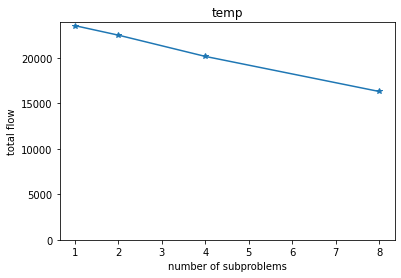

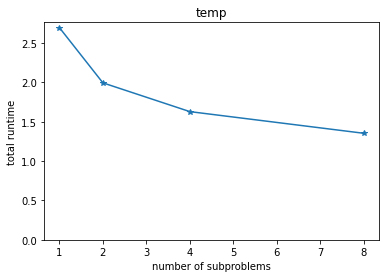

In [26]:
for p in problems:
    total_obj_values = []
    for n_i, n in enumerate(num_subproblems):
        sum_val = sum(results[p][n_i])
        total_obj_values.append(sum_val)
    fig, ax = plt.subplots()
    ax.plot(num_subproblems, total_obj_values, marker='*')
    ax.set_title(p[0])
    plt.xlabel('number of subproblems')
    plt.ylabel('total flow')
    plt.ylim([0,None])
    
for p in problems:
    total_runtime = []
    for n_i, n in enumerate(num_subproblems):
        sum_val = sum(runtimes[p][n_i])
        total_runtime.append(sum_val)
    fig, ax = plt.subplots()
    ax.plot(num_subproblems, total_runtime, marker='*')
    ax.set_title(p[0])
    plt.xlabel('number of subproblems')
    plt.ylabel('total runtime')
    plt.ylim([0,None])
    
#print(results)
    

In [29]:
problem = Problem.from_file("../topologies/topology-zoo/GtsCe.graphml", 
                            "../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl")
problem.G
#print(problem.G.edges.data())
print(problem.commodity_list)
#problem2 = problem.copy()
#print(dir(problem))
"""
problem2.traffic_matrix.tm
new_tm = problem2.traffic_matrix.tm[0:10,:]

num_rows = len(problem2.traffic_matrix.tm)

shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)

num_first_problem = math.floor(num_rows/2)

for i in shuffled_indices[1:num_first_problem]:
    problem2.traffic_matrix.tm[i,:] = 0

#print(problem2.traffic_matrix.tm[1:5,:])

for u,v in problem.G.edges:
    problem.G[u][v]['capacity'] = problem.G[u][v]['capacity']/2
    problem2.G[u][v]['capacity'] = problem2.G[u][v]['capacity']/2
"""

[(0, (0, 1, 0.7263322)), (1, (0, 2, 2.5183077)), (2, (0, 3, 2.0793297)), (3, (0, 4, 2.2596655)), (4, (0, 5, 2.5529218)), (5, (0, 6, 3.0862205)), (6, (0, 7, 1.8528175)), (7, (0, 8, 1.7015175)), (8, (0, 9, 2.714255)), (9, (0, 10, 2.8732836)), (10, (0, 11, 1.2399839)), (11, (0, 12, 2.1324372)), (12, (0, 13, 2.5891871)), (13, (0, 14, 3.1648793)), (14, (0, 15, 2.2027094)), (15, (0, 16, 1.9900347)), (16, (0, 17, 2.3219056)), (17, (0, 18, 2.927682)), (18, (0, 19, 2.090259)), (19, (0, 20, 2.901464)), (20, (0, 21, 0.4159191)), (21, (0, 22, 1.2076716)), (22, (0, 23, 1.2992105)), (23, (0, 24, 3.1996243)), (24, (0, 25, 1.5959072)), (25, (0, 26, 0.3332264)), (26, (0, 27, 2.1030219)), (27, (0, 28, 2.883922)), (28, (0, 29, 1.672964)), (29, (0, 30, 1.0318842)), (30, (0, 31, 1.2557812)), (31, (0, 32, 1.8910482)), (32, (0, 33, 1.9461508)), (33, (0, 34, 1.3165586)), (34, (0, 35, 1.547859)), (35, (0, 36, 1.8606155)), (36, (0, 37, 0.73599637)), (37, (0, 38, 1.8031895)), (38, (0, 39, 1.2506183)), (39, (0, 4

"\nproblem2.traffic_matrix.tm\nnew_tm = problem2.traffic_matrix.tm[0:10,:]\n\nnum_rows = len(problem2.traffic_matrix.tm)\n\nshuffled_indices = list(range(num_rows))\nrandom.shuffle(shuffled_indices)\n\nnum_first_problem = math.floor(num_rows/2)\n\nfor i in shuffled_indices[1:num_first_problem]:\n    problem2.traffic_matrix.tm[i,:] = 0\n\n#print(problem2.traffic_matrix.tm[1:5,:])\n\nfor u,v in problem.G.edges:\n    problem.G[u][v]['capacity'] = problem.G[u][v]['capacity']/2\n    problem2.G[u][v]['capacity'] = problem2.G[u][v]['capacity']/2\n"